A notebook to fit with Celerite light curves from Zeljko ( email June 9, 2017 ) 




In [2]:
import numpy as np 
import os
import datetime
from itertools import product
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

import celerite
import numpy as np
import matplotlib.pyplot as plt
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column


In [12]:
np.sqrt(2) * 0.2

0.28284271247461906

Input properties for each of the 1000 light curves  : 

  $\tau_{in} = 100 $ days
   
  $\sigma_{in} = 0.2  $ mag

  $SF_{\infty} = 0.2*\sqrt{2} = 0.2828$ mag

length = $l= 20 \tau$

dt = 5 days 

random sampling  from a uniform distribution 

yerr = 0.001  mag 

400 points 

## Plot the Structure Function ... 


In [93]:
len(files)

1000

In [17]:
len(delta_m)

79800

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs

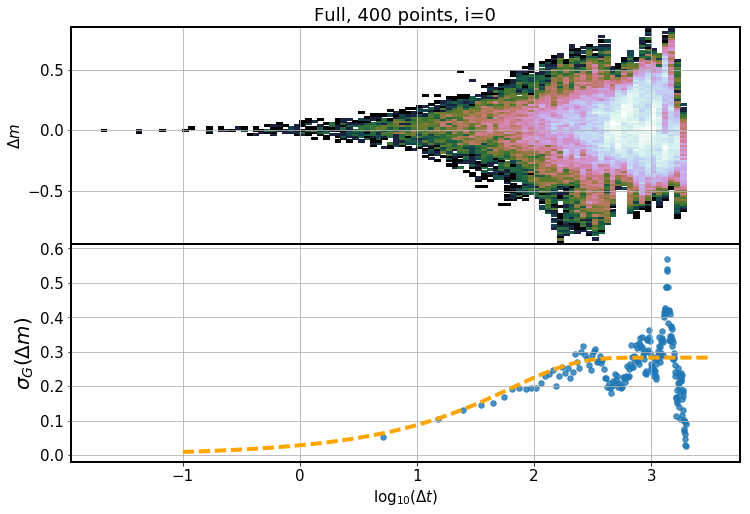

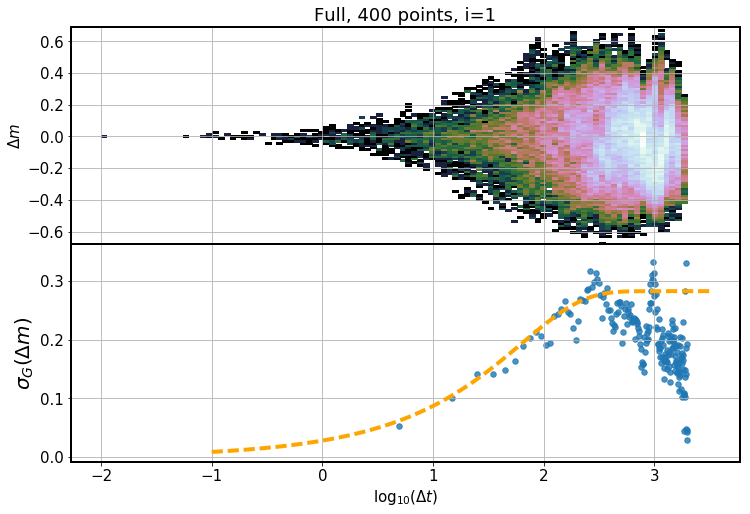

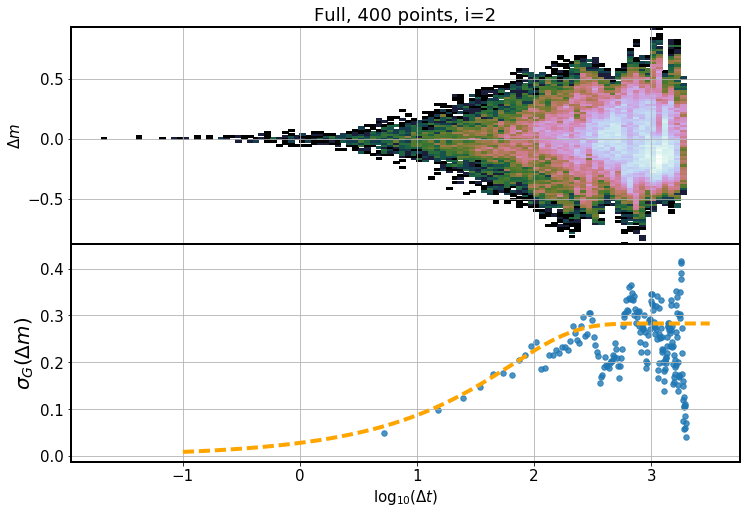

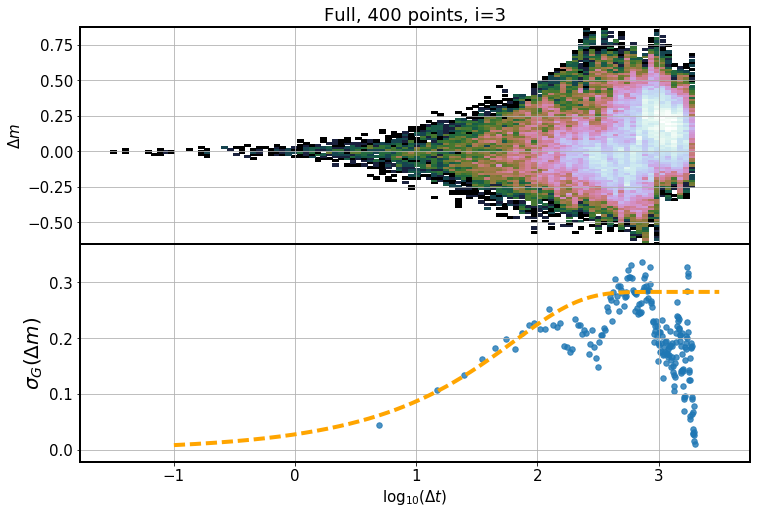

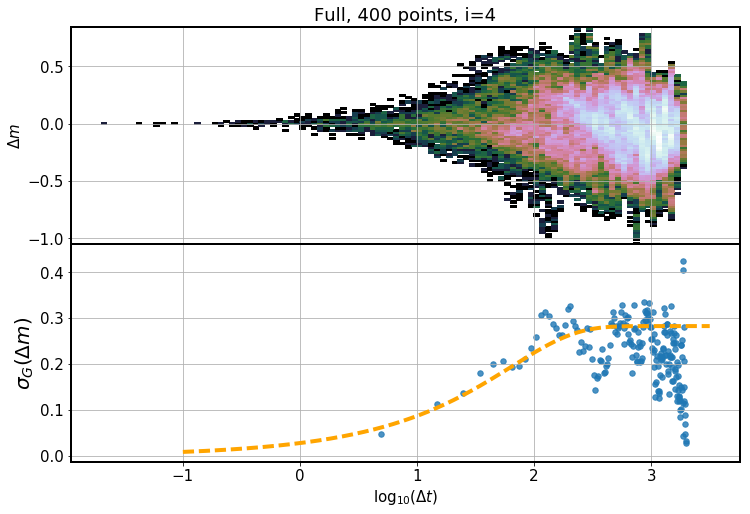

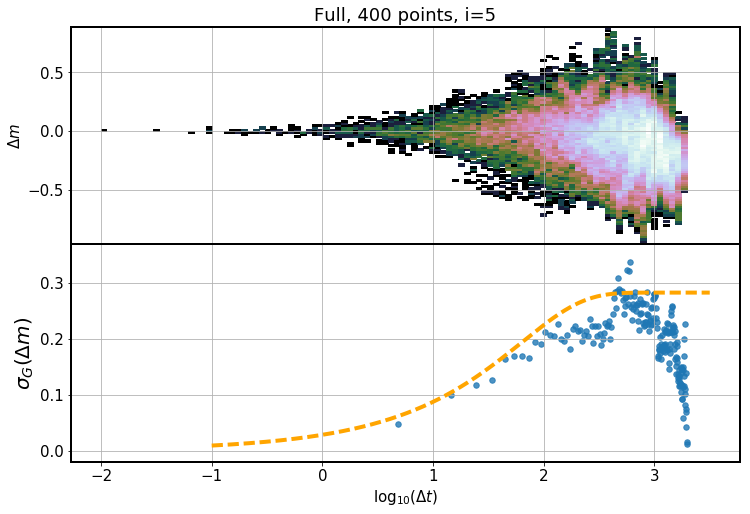

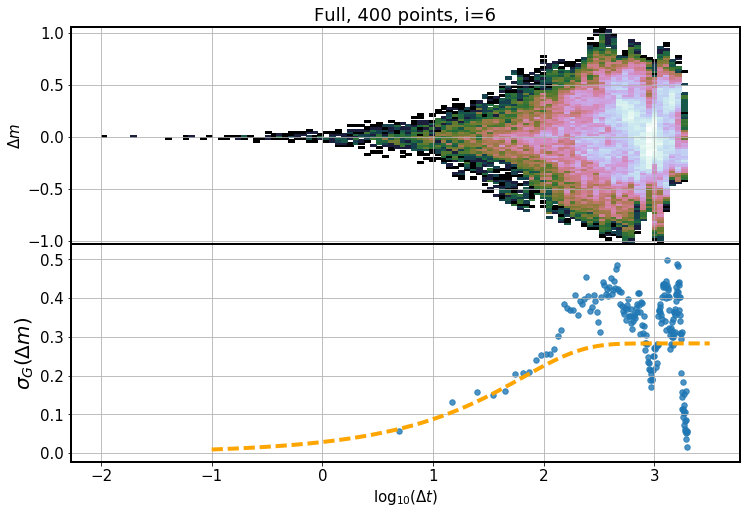

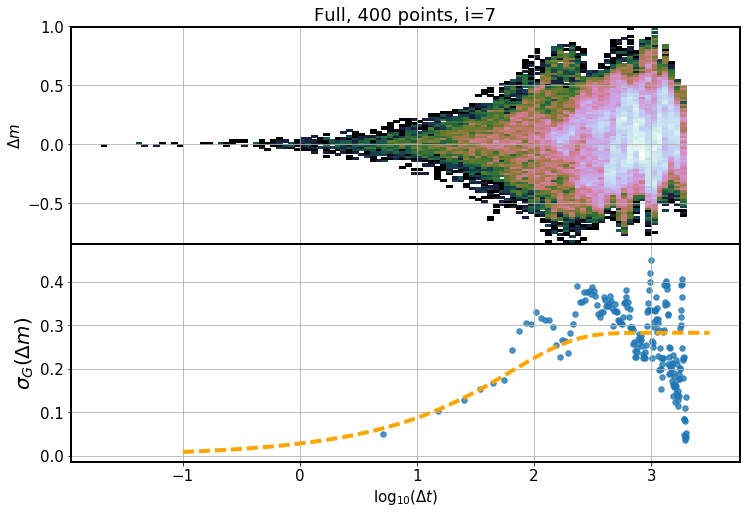

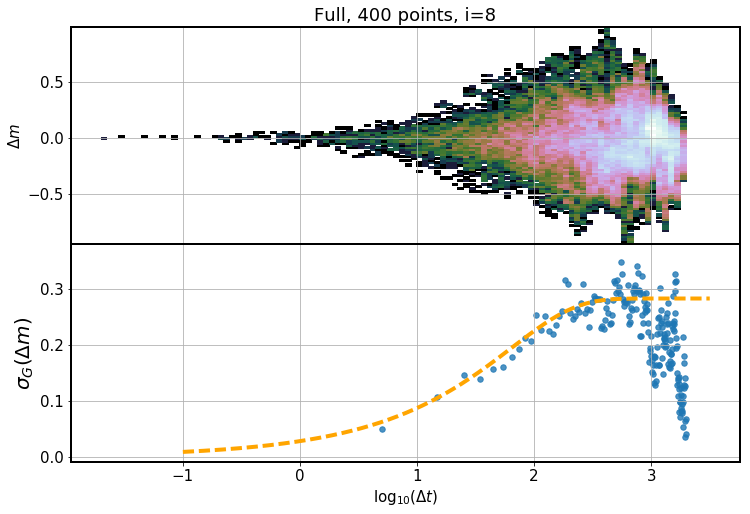

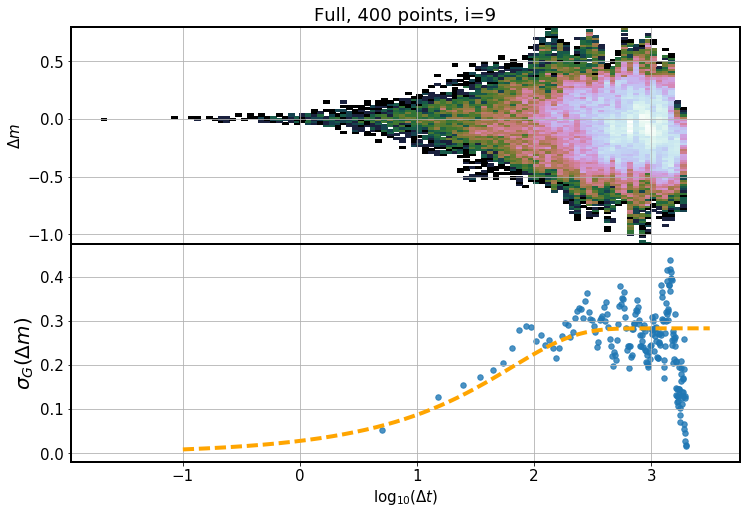

In [107]:
%matplotlib inline 

# read - in the lightcurve 
DirIn = '../raw_data/DRWtestCeleriteZI/'
files = os.listdir(DirIn)
for i in range(10):
    lc = Table.read(DirIn +files[i], format='ascii', names=['time', 'mag', 'err'] )

    # calculate the delta_mag array ... 
    # it's very quick for just 400 points ...
    t,y = lc['time'], lc['mag']

    delta_m = []; delta_t = []

    for j in range(len(y)-1):
        for k in range(j+1):     
            delta_t.append(t[j+1]-t[k])  # j from 1 and k<j
            delta_m.append((y[k]-y[j+1]))  


    # sometimes we have observations at the same time  - -
    # need to remove that ... 
    mask  = np.array(delta_t) != 0
    delta_t = np.array(delta_t) [ mask ]
    delta_m = np.array(delta_m) [ mask ]    

    # plot the structure function...
    # Plot the raw data... 
    import colorcet as cc
    from matplotlib.colors import ListedColormap
    #cmap = ListedColormap(cc.colorwheel)
    cmap = 'cubehelix'

    fig,ax = plt.subplots(2,1,figsize=(12,8), sharex=True)

    xdata = np.log10(delta_t)
    ydata =  delta_m
    H, xedges, yedges = np.histogram2d(xdata,ydata, bins=100)
    H = np.rot90(H)
    H = np.flipud(H)
    Hmasked = np.ma.masked_where(H==0,H)

    image  = ax[0].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap=cmap)
    #colorbar = plt.colorbar(image)

    ax[0].set_ylabel(r'$\Delta m$',fontsize=15)
    ax[0].grid()

    nbins = 200
    from scipy.stats import binned_statistic
    binned_tau = binned_statistic(delta_t, delta_t, statistic='mean', bins=nbins)

    # calculate st.dev.
    #rms_std = lambda x : np.std(x)
    #stdev_binned = binned_statistic(delta_t, delta_m, statistic = rms_std, 
                                       #   bins=nbins)
    # Plot sigmaG  :
    sigmaG = lambda x : 0.7414 *(np.percentile(x,75) - np.percentile(x,25))
    binned_sigmaG= binned_statistic(delta_t, delta_m, statistic = sigmaG, 
                                          bins=nbins)

    # Add theoretical SF .. 
    def model_sf(t, sf_inf=0.2 * np.sqrt(2), tau = 100):
        br = 1.0-np.exp(-t/tau)
        sf = sf_inf * np.power(br,0.5)
        return sf

    ax[1].scatter(np.log10(binned_tau[0]), binned_sigmaG[0], s=30, alpha=0.8)
    t = np.logspace(-1,3.5,1000)
    ax[1].plot(np.log10(t), model_sf(t), ls='--', lw=4, color='orange')
    ax[1].grid()
    ax[1].set_xlabel(r'$\log_{10}(\Delta t )$', fontsize=15)
    ax[1].set_ylabel(r'$\sigma_{G}(\Delta m)$')

    fig.subplots_adjust(hspace=0)
    ax[0].set_title('Full, 400 points, i='+str(i))
    plt.savefig(outDir + 'DRW_SF_'+str(i)+'.png')

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in log10


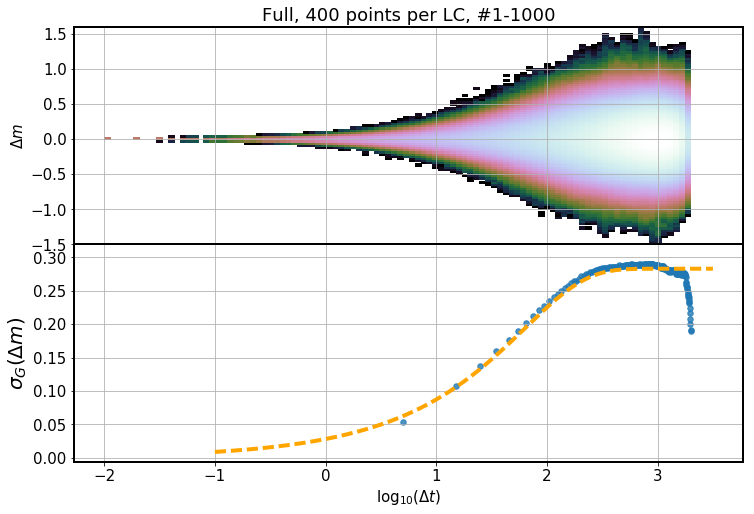

In [114]:
# Take 100 lightcurves and use them together ...

dt_arr = np.zeros(0,dtype=float)
dm_arr = np.zeros(0,dtype=float)

N_LC = 1000 
for i in range(N_LC) : 
    lc = Table.read(DirIn +files[i], format='ascii', names=['time', 'mag', 'err'] )

    # calculate the delta_mag array ... 
    # it's very quick for just 400 points ...
    t,y = lc['time'], lc['mag']

    delta_m = []; delta_t = []

    for j in range(len(y)-1):
        for k in range(j+1):     
            delta_t.append(t[j+1]-t[k])  # j from 1 and k<j
            delta_m.append((y[k]-y[j+1]))  


    # sometimes we have observations at the same time  - -
    # need to remove that ... 
    mask  = np.array(delta_t) != 0
    delta_t = np.array(delta_t) [ mask ]
    delta_m = np.array(delta_m) [ mask ]   
    
    dt_arr = np.append(dt_arr, delta_t)
    dm_arr = np.append(dm_arr, delta_m)
    

# plot the structure function...
# Plot the raw data... 
import colorcet as cc
from matplotlib.colors import ListedColormap
#cmap = ListedColormap(cc.colorwheel)
cmap = 'cubehelix'

fig,ax = plt.subplots(2,1,figsize=(12,8), sharex=True)

delta_t = dt_arr
delta_m = dm_arr 

xdata = np.log10(delta_t)
ydata =  delta_m

H, xedges, yedges = np.histogram2d(xdata,ydata, bins=100)
H = np.rot90(H)
H = np.flipud(H)
Hmasked = np.ma.masked_where(H==0,H)

image  = ax[0].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap=cmap)
#colorbar = plt.colorbar(image)

ax[0].set_ylabel(r'$\Delta m$',fontsize=15)
ax[0].grid()

nbins = 200
from scipy.stats import binned_statistic
binned_tau = binned_statistic(delta_t, delta_t, statistic='mean', bins=nbins)

# calculate st.dev.
#rms_std = lambda x : np.std(x)
#stdev_binned = binned_statistic(delta_t, delta_m, statistic = rms_std, 
                                   #   bins=nbins)
# Plot sigmaG  :
sigmaG = lambda x : 0.7414 *(np.percentile(x,75) - np.percentile(x,25))
binned_sigmaG= binned_statistic(delta_t, delta_m, statistic = sigmaG, 
                                      bins=nbins)

# Add theoretical SF .. 
def model_sf(t, sf_inf=0.2 * np.sqrt(2), tau = 100):
    br = 1.0-np.exp(-t/tau)
    sf = sf_inf * np.power(br,0.5)
    return sf


ax[1].scatter(np.log10(binned_tau[0]), binned_sigmaG[0], s=30, alpha=0.8)
t = np.logspace(-1,3.5,1000)
ax[1].plot(np.log10(t), model_sf(t), ls='--', lw=4, color='orange')
ax[1].grid()
ax[1].set_xlabel(r'$\log_{10}(\Delta t )$', fontsize=15)
ax[1].set_ylabel(r'$\sigma_{G}(\Delta m)$')

fig.subplots_adjust(hspace=0)
ax[0].set_title('Full, 400 points per LC, #1-'+str(N_LC))
plt.savefig(outDir + 'DRW_SF_'+str(N_LC)+'_LC.png')

## Celerite fitting .... 

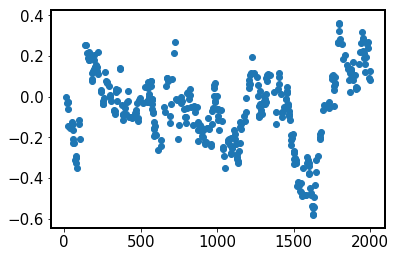

In [2]:
# read the first lightcurve and see what it looks like...
DirIn = '../raw_data/DRWtestCeleriteZI/'
files = os.listdir(DirIn)
lc = Table.read(DirIn +files[0], format='ascii', names=['time', 'mag', 'err'] )

%matplotlib inline

plt.scatter(lc['time'],lc['mag'])

In [94]:
i  =430
i % 100

30

In [3]:
# Make a dir for the results 
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_Celerite_ZI_LC_fits',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)


We will save this figure in  /Users/chris/GradResearch/DRW_Celerite/data_products/Fig_Celerite_ZI_LC_fits/2017-06-23/


In [89]:
# Fitting  : each light curve is fit with various settings : 
# [ no_bounds,  with_bounds ] X [ flat_prior , exp_prior]

t,y,yerr = lc['time'], lc['mag'], lc['err']

sigma_bounds = [0.01, 1.0]
tau_bounds = [1,10000]

results = {}
for use_bounds in [False, True]:
    results[use_bounds] = {}
    for prior in ['flat', 'exp']:
        results[use_bounds][prior] = {'sigma_fit':np.zeros(len(files), dtype=float),
                                      'tau_fit':np.zeros(len(files), dtype=float)}
        
for i in range(len(files)) :
    if (i % 100)== 0 : 
        print(i)
    lc = Table.read(DirIn +files[i], format='ascii', names=['time', 'mag', 'err'] )
    # read in Zeljko's light curve 
    
    t,y,yerr = lc['time'], lc['mag'], lc['err']
    
    # fitting procedure : 
    # initialize the kernel ... 
    kernel = terms.RealTerm(log_a = 2 * np.log(sigma_in) , 
                            log_c = np.log(1/tau_in))
    
    # call the model 
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)
    
    # 
    initial_params = gp.get_parameter_vector()

    for use_bounds, prior in product([True,False], ['flat', 'exp']):    
        if use_bounds : # use some custom boundaries 
            logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
            loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
            bounds = [loga_bounds, logc_bounds]
        else : # use the built-in boundaries (-inf : +inf )
            bounds = gp.get_parameter_bounds()
            
        if prior is 'flat' : 
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)

        if prior is 'exp' :
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                log_a = params[0]
                log_c = params[1]
                return -gp.log_likelihood(y)  -log_c + log_a / 2.0  #-log_c - log_a 
        # do the scipy optimize to find the maximum likelihood estimator 
        # for hyperparameters.... 
        #print('Using %s prior'%prior)
        r = minimize(neg_log_like, initial_params, 
                     method="L-BFGS-B", bounds=bounds, args=(y, gp))
        gp.set_parameter_vector(r.x)
        res = gp.get_parameter_dict()
        sigma_fit = np.exp(res['kernel:log_a']/2)
        tau_fit = 1.0 / np.exp(res['kernel:log_c'])
        results[use_bounds][prior]['sigma_fit'][i] = sigma_fit
        results[use_bounds][prior]['tau_fit'][i] = tau_fit
        
# Save the results ...
np.save(outDir+'celerite_ZI_LC_fit_results_N.npy', results)        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

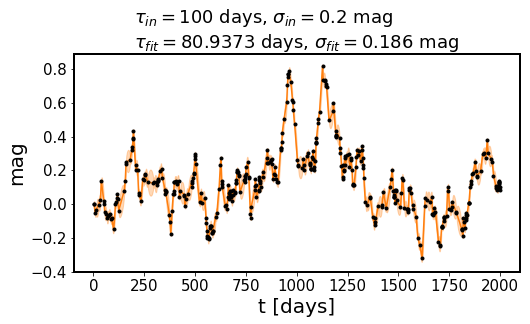

In [90]:
# Plot the light curve and the prediction .... 

# quantities for plotting ... 
x = np.linspace(min(t),max(t) , 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
ax.plot(x, pred_mean, color=color)
ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
ax.set_xlabel('t [days]')
ax.set_ylabel('mag')

title = r'$\tau_{in}=$'+str(tau_in)+' days, ' +\
r'$\sigma_{in}=$'+str(sigma_in)+' mag'+'\n'\
       +r'$\tau_{fit}=$'+str(tau_fit)[:7]+' days, '+\
    r'$\sigma_{fit}=$'+str(sigma_fit)[:5]+' mag'

ax.set_title(title,multialignment='left')
#ax.text(0.1*max(t), 0.1*max(y),)
plt.savefig(outDir+'DRW_fit_length-20_dt-5_err_0.001.png', bbox_inches='tight')





/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log10


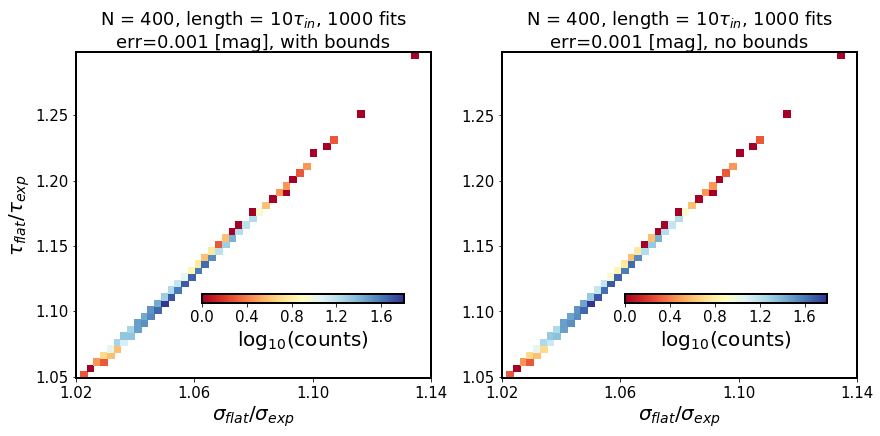

In [91]:
%matplotlib inline
from scipy.stats import binned_statistic_2d

import matplotlib.gridspec as gridspec
fig,ax = plt.subplots(1,2,figsize=(14,6))


i = 0 
x0 = [0.25, 0.67]
for use_bounds in [True,False]: 
    if use_bounds :
        b = 'with bounds'
    else: 
        b = 'no bounds'
    
    sig1 = results[use_bounds]['flat']['sigma_fit']
    sig2 = results[use_bounds]['exp']['sigma_fit']
    
    tau1 = results[use_bounds]['flat']['tau_fit']
    tau2 = results[use_bounds]['exp']['tau_fit']

    x =   sig1 / sig2
    y =  tau1 / tau2
    #xmin, xmax = 1-0.0006, 1+0.0006
    #ymin, ymax = 1.0095, 1.0125
    #m = (xmin < x) * (x < xmax) * (ymin<y) * (y<ymax)

    ax[i].set_title('N = '+str(len(t))+', length = 10'+  r'$ \tau_{in}$,'+' '\
                 +str(len(sig1))+' fits' + '\n' \
                 + 'err='+str(yerr[0])+' [mag], '+b)
    
    # Plot 2D histogram using pcolor
    stats = binned_statistic_2d(x, y, x, statistic='count', bins=50)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
    image = ax[i].pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                             cmap=plt.cm.get_cmap('RdYlBu'))
    
    ax[i].set_xlabel(r'$\sigma_{flat}/ \sigma_{exp}$')
    
    cax = fig.add_axes([x0[i], 0.3, 0.2,0.02])
    colorbar = fig.colorbar(image, cax=cax, orientation='horizontal')
    from matplotlib import ticker
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()
    colorbar.set_label(r'$\log_{10}(\mathrm{counts})$')
    
    xticks = ax[i].get_xticks()
    ax[i].set_xticks(xticks[::2])
    
    i += 1 

ax[0].set_ylabel(r'$\tau_{flat} / \tau_{exp}$')

fig.subplots_adjust(wspace=0.2)
plt.savefig(outDir+'DRW_priors_bounds_comp1.png')

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10


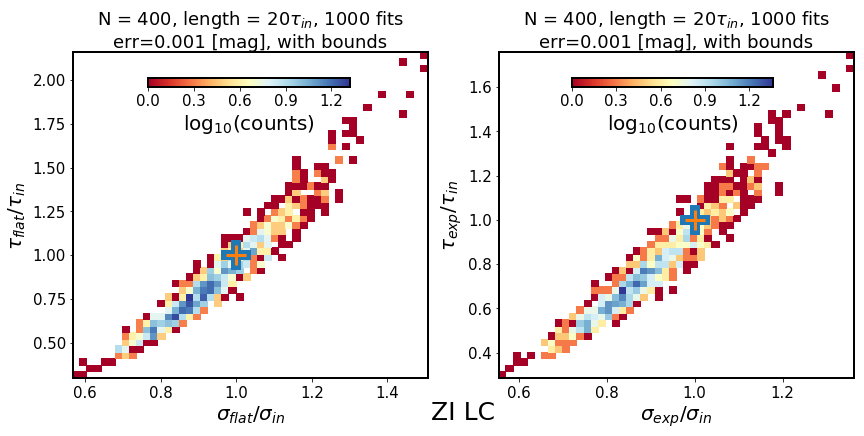

In [92]:
# Make another plot  : showing  the ratios of   tau_fit to  tau_in  ,  and 
# sigma_fit  to sigma_in 
%matplotlib inline
from scipy.stats import binned_statistic_2d
fig,ax = plt.subplots(1,2,figsize=(14,6))

use_bounds  = True
b = 'with bounds'
length = 20 
i = 0 
x0 = [0.2,0.62]
for prior in ['flat', 'exp']:
    x =  results[use_bounds][prior]['sigma_fit'] / sigma_in
    y = results[use_bounds][prior]['tau_fit'] / tau_in

    ax[i].set_title('N = '+str(len(t))+', length = '+str(length)+  r'$ \tau_{in}$,'+' '\
                 +str(len(x))+' fits' + '\n' \
                 + 'err='+str(yerr[0])+' [mag], '+b)

    # Plot 2D histogram using pcolor
    stats = binned_statistic_2d(x, y, x, statistic='count', bins=50)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
    image = ax[i].pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                             cmap=plt.cm.get_cmap('RdYlBu'))

    
    cax = fig.add_axes([x0[i], 0.8, 0.2,0.02])
    colorbar = fig.colorbar(image, cax=cax, orientation='horizontal')
    from matplotlib import ticker
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()
    colorbar.set_label(r'$\log_{10}(\mathrm{counts})$')

    #xticks = ax[0].get_xticks()
    #ax[0].set_xticks(xticks[::2])
    ax[i].plot(1,1,marker='+', markersize=30,markerfacecolor='yellow', 
         markeredgewidth=10.0)
    ax[i].plot(1,1,marker='+', markersize=20,markerfacecolor='red', 
         markeredgewidth=3.0)
    i += 1 
    
ax[0].set_xlabel(r'$\sigma_{flat}/ \sigma_{in}$')
ax[0].set_ylabel(r'$\tau_{flat} / \tau_{in}$')
ax[1].set_xlabel(r'$\sigma_{exp}/ \sigma_{in}$')
ax[1].set_ylabel(r'$\tau_{exp} / \tau_{in}$')

fig.text(0.48,0.03,'ZI LC', fontsize=25)
fig.subplots_adjust(wspace=0.2)
plt.savefig(outDir+'DRW_priors_comp1.png')

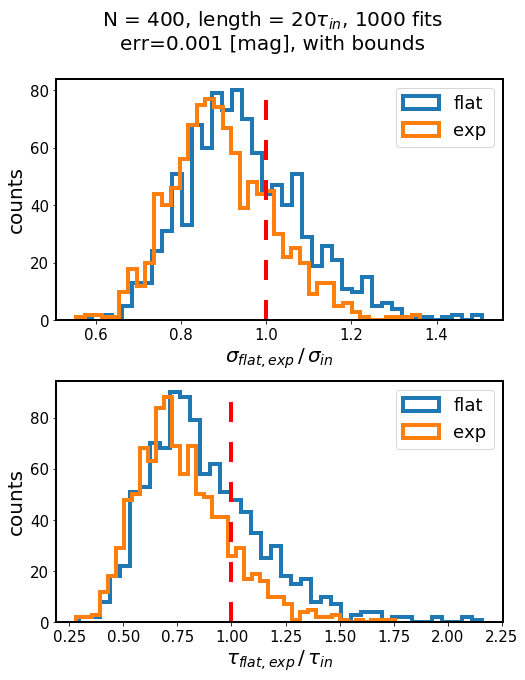

In [87]:
# plot histograms : marginalize along either dimension ... 

fig ,ax  = plt.subplots(2,1,figsize=(8,10))

# two panels  : tau and sigma 

use_bounds  = True
b = 'with bounds'
length = 20 
i = 0 
x0 = [0.2,0.62]
for prior in ['flat', 'exp']:
    x =  results[use_bounds][prior]['sigma_fit'] / sigma_in
    ax[0].hist(x, label = prior, histtype='step', lw=4, bins=40)

    y = results[use_bounds][prior]['tau_fit'] / tau_in
    ax[1].hist(y, label=prior, histtype='step', lw=4, bins=40)

ax[0].set_xlabel(r'$\sigma_{flat,exp}\,/ \,\sigma_{in}$')
ax[1].set_xlabel(r'$\tau_{flat,exp} \,/\, \tau_{in}$')
for i in [0,1]:
    ax[i].legend(fontsize=18)
    ax[i].axvline(1, lw=4, ls='--', c='red', dashes=(5,5))
    ax[i].set_ylabel('counts')
fig.subplots_adjust(hspace=0.25)
fig.suptitle('N = '+str(len(t))+', length = '+str(length)+  r'$ \tau_{in}$,'+' '\
                 +str(len(x))+' fits' + '\n' \
                 + 'err='+str(yerr[0])+' [mag], '+b, fontsize=20)
plt.savefig(outDir + 'sigma_tau_ratios_marginalized.png')
# in each panel , plot histogram of both 

Now, above I was fitting Zeljko's light curves. Below I reproduce such light curves with my code, and 

a) show that keeping all parameters as above ($\tau=100$, $\sigma=0.2$, baseline = $20 \tau$, and N=400), 
the marginalized distribution of fit results to input will be the same. Then 

b)  I repeat the experiment inreasing the number of points to 800, and 1600,  but keep the baseline fixed. In other words, I decrese the sampling interval from 2000 / 400 = 5 days, to 2.5 and 1.25 day 

NOTE : since amazingly flat prior is less biased than Johnson prior,  I decided to just use flat prior, so that our result is not affected by poor choice of prior ... 

NOTE : I choose to fit with bounds, because it almost doesn't matter ( as I showed on plots from 2017-06-10 ) ,  and it makes sense that very loose bounds would not affect my result too much anyway ... 

In [5]:
# Simulate the same input at Zeljko ... 

def sim_DRW_lightcurve(t,SFinf,tau,mean_mag):
    '''Simulate a DRW lightcurve for a given time series t, with parameters
       (SFinf, tau), and mean magnitude.
       Uses equations A4 and A5 in Kelly 2009 (see also MacLeod+10 sec 2.2).'''
    mu = mean_mag  # the input parameter : mean mag: make an alias 
    mag = np.zeros(len(t),dtype=np.float32) # initialize an array of empty values
    mag[0] = mean_mag # start from the mean magnitude 
    dt = np.diff(t) # an array of differences  t[i+1]-t[i]
    for i in range(1,len(t)):
        # calculate the mean 
        loc = np.exp(-dt[i-1]/tau)*mag[i-1] + mu*(1-np.exp(-dt[i-1]/tau))
        # calculate the variance 
        var = 0.5 * SFinf**2 * (1-np.exp(-2*dt[i-1]/tau))
        # draw the magnitude value from a Gaussian distribution
        # with a given mean and standard deviation ( = sqrt(variance))
        mag[i] = np.random.normal(loc=loc,scale=np.sqrt(var))
    return mag


def sampling(tau_in = 100, length=10, t_min=1, N_pts = None,  dt = 10 , 
                        regular=False, verbose=False):
    ''' A convenience function to return user-defined sampling 
    
    Input: 
    -------
    tau_in : input timescale (default: 100 days )
    length : length in terms of multiples of timescale (default: 10) 
    t_min : starting point of lightcurve (default : 1 )
    N_pts: if provided , then we choose the dt based on the number 
         of points desired. Otherwise the number of points is 
         calculated based on the desired spacing. 
    dt : interval between samplings, if regular = True, then 
        this is the exact interval,  otherwise we divide the 
        light curve length by dt to determine the number 
        of points 
    regular : boolean (True / False). Use regular sampling with dt, 
        or random sampling with Npts = floor(total_timespan / dt) ? 
        
    Returns:
    ---------
    t : sampling times 
    '''
    t_max = t_min + length*tau_in
    if regular : 
        # evenly spaced sampling within the chosen interval 
        if verbose: 
            print('Using regular sampling')
        if N_pts is None : 
            t = np.arange(t_min, t_max, dt)
        else : 
            t = np.linspace(t_min, t_max, N_pts)
    else :
        # random sampling with the chosen number of points ... 
        # The output is sorted
        if verbose: 
            print('Using random sampling')
        if N_pts is None : 
            N_pts= int(np.floor((t_max - t_min) / dt))
        t = np.sort(np.random.uniform(t_min, t_max, N_pts)) 
        
    return t

t = sampling(regular=True)


# Make a todays dir to save the figure ...
outDir = os.path.join(os.getcwd()[:-len('code')],'data_products/Fig_Celerite_simulated_LC',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)




We will save this figure in  /Users/chris/GradResearch/DRW_Celerite/data_products/Fig_Celerite_simulated_LC/2017-07-19/


We make the following choices (as Zeljko did ) for input properties for each of the 1000 light curves  (experimenting with light curve N points...) 

$\tau_{in} = 100 $ days

$\sigma_{in} = 0.2  $ mag

$SF_{\infty} = 0.2*\sqrt{2} = 0.2828$ mag

length = $l= 20 \tau$

random sampling  from a uniform distribution 

yerr = 0.001  mag 

400 points 


   a) dt = 5 days 
  
   b) dt = 2.5 days , 800 points 
  
   c) dt = 1.25 days, 1600 points 





In [24]:
from itertools import product

# Make 100  realizations of this lightcurve,
# with identical parameters, 
# and make 1 fit each time since as shown above,
# they are completely repeatable ...
# save each lightcurve  by putting it into a dic and then pickling
# the dic with np.save 
# record the results of each fit 

# First set of parameters :  making the light curves in first attempt , 
# that were then  reproduced by Zeljko
# tau_in = 100    ;    sigma_in = 0.2    ;   yerr = 0.001  ,  length = 20   ;  
# dt = 5  ;  N_iterations = 1000   
# sigma_bounds = [0.01, 1.0 ]     ;  tau_bounds = [1 , 10 000]
# This results in a lightcurve that has 400 points 

# We make longer ligh curves   if  we keep  sigma_in,   yerr,  bounds and N_iter 
# unchanged,   but we 
# a) make the baseline longer : keep  dt = 5,  but set length = 100  == setup_1
# b) keep the baseline unchanged,  keep length = 20,  but set dt = 1 == setup_2

# generic setup for input :  doesn't change 
regular_sampling = False
yerr =  0.001 # mags 
tau_in = 100 # days 
length = 20 
sigma_in = 0.2 # mags 
SF_inf = sigma_in * np.sqrt(2)
dt = 1.25 / 2.0
N_iterations =  1000

sigma_bounds = [0.01, 1.0]
tau_bounds = [1,10000]

fit_setup = {'sigma_in':sigma_in, 'tau_in':tau_in, 
             'sigma_bounds':sigma_bounds, 'tau_bounds':tau_bounds,
             'yerr' : yerr, 'length':length, 'dt' :dt,
             'regular_sampling':regular_sampling
            }

results = {}
for use_bounds in [False, True]:
    results[use_bounds] = {}
    for prior in ['flat', 'log']:
        results[use_bounds][prior] = {'sigma_fit':np.zeros(N_iterations, dtype=float),
                                      'tau_fit':np.zeros(N_iterations, dtype=float)}
for i in range(N_iterations) :
    # At each iteration we simulate a new DRW with 
    # the same input parameters, so 
    # it makes sense that 
    # all loops over the setup of fitting 
    # procedure : using bounds, or using prior,  are 
    # within here .
    if (i % 100) == 0 : 
        print(i)

    # The input time coordinates must be sorted
    t = sampling(tau_in = tau_in, length=length, regular=regular_sampling, dt=dt)
    y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)
    #LC_save[i] = {'t':t, 'y':y, 'yerr':yerr} 

    # fitting procedure : 
    # initialize the kernel ... 
    log_a_in = 2 * np.log(sigma_in)
    log_c_in = np.log(1/tau_in)
    kernel = terms.RealTerm(log_a = log_a_in , log_c = log_c_in)

    # call the model 
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)

    # optimization of the results 
    initial_params = gp.get_parameter_vector()
    for use_bounds, prior in product([True,False], ['flat', 'log']):
        
        if use_bounds : # use some custom boundaries 
            logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
            loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
            bounds = [loga_bounds, logc_bounds]
        else : # use the built-in boundaries (-inf : +inf )
            bounds = gp.get_parameter_bounds()
            
        if prior is 'flat' : 
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)

        if prior is 'log' :
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                log_a = params[0]
                log_c = params[1]
                log_prior = 1.5 * log_c - 0.5* log_a + 0.5 *np.log(2) 
                return -gp.log_likelihood(y)  -log_prior
        # do the scipy optimize to find the maximum likelihood estimator 
        # for hyperparameters.... 
        #print('Using %s prior'%prior)
        r = minimize(neg_log_like, initial_params, 
                     method="L-BFGS-B", bounds=bounds, args=(y, gp))
        gp.set_parameter_vector(r.x)
        res = gp.get_parameter_dict()
        sigma_fit = np.exp(res['kernel:log_a']/2)
        tau_fit = 1.0 / np.exp(res['kernel:log_c'])
        results[use_bounds][prior]['sigma_fit'][i] = sigma_fit
        results[use_bounds][prior]['tau_fit'][i] = tau_fit
        
np.save(outDir+'DRW_ZI_setup_d.npy',  fit_setup)
np.save(outDir+'DRW_ZI_results_d.npy', results)

print('Done')

0
100
200
300
400
500
600
700
800
900
Done


In [25]:
# load the results ...
test = 'd'
setup = np.load(outDir+'DRW_ZI_setup_'+test+'.npy').item()
results = np.load(outDir+'DRW_ZI_results_'+test+'.npy').item()
setup

{'dt': 0.625,
 'length': 20,
 'regular_sampling': False,
 'sigma_bounds': [0.01, 1.0],
 'sigma_in': 0.2,
 'tau_bounds': [1, 10000],
 'tau_in': 100,
 'yerr': 0.001}

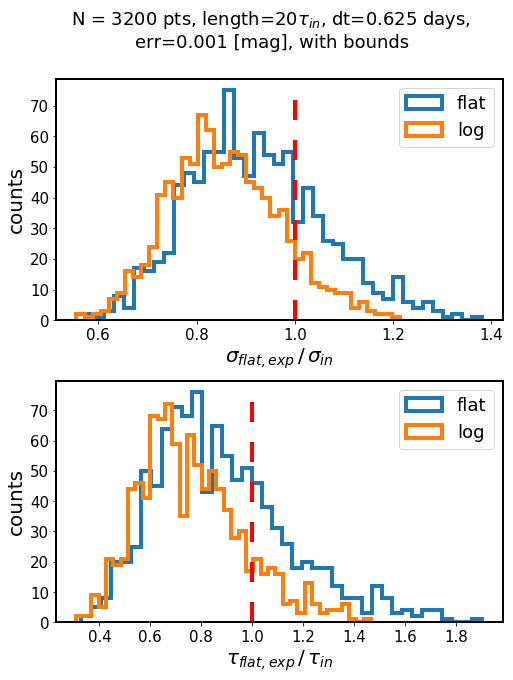

In [27]:
%matplotlib inline
# plot histograms : marginalize along either dimension ... 

fig ,ax  = plt.subplots(2,1,figsize=(8,10))

# two panels  : tau and sigma 

use_bounds  = True
b = 'with bounds'
length = setup['length']
dt = setup['dt']
tau_in = setup['tau_in']
sigma_in = setup['sigma_in']
yerr = setup['yerr']
N = int((length * tau_in) / dt)
i = 0 
x0 = [0.2,0.62]
for prior in ['flat', 'log']:
    x =  results[use_bounds][prior]['sigma_fit'] / sigma_in
    ax[0].hist(x, label = prior, histtype='step', lw=4, bins=40)

    y = results[use_bounds][prior]['tau_fit'] / tau_in
    ax[1].hist(y, label=prior, histtype='step', lw=4, bins=40)

ax[0].set_xlabel(r'$\sigma_{flat,exp}\,/ \,\sigma_{in}$')
ax[1].set_xlabel(r'$\tau_{flat,exp} \,/\, \tau_{in}$')
for i in [0,1]:
    ax[i].legend(fontsize=18)
    ax[i].axvline(1, lw=4, ls='--', c='red', dashes=(5,5))
    ax[i].set_ylabel('counts')
fig.subplots_adjust(hspace=0.25)

fig.suptitle('N = '+str(N)+' pts, length='+str(length)+ r'$ \tau_{in}$'+', dt='+\
             str(dt)+' days, \n'  + '' \
                 + 'err='+str(yerr)+' [mag], '+b, fontsize=18)


plt.savefig(outDir + 'DRW_prior_marginalized_setup_'+test+'.png', bbox_inches='tight')
# in each panel , plot histogram of both 

In experiment a) we start with dt = 5 days, and then increase the sampling density by a factor of  2,4,8 ,  so that dt becomes 2.5, 1.25, and  0.625 , and number of points per LC jumps from 400  , to 800, 1600, and 3200. 

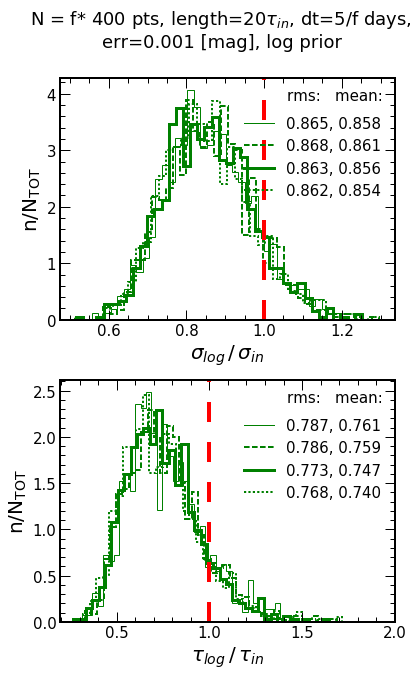

In [64]:
# COMBINED ... 
# Plot altogether the three results of increasing the sampling density .... 
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
%matplotlib inline
# plot histograms : marginalize along either dimension ... 
fig ,axs = plt.subplots(2,1,figsize=(6,10))
ax = np.ravel(axs)

# two panels  : tau and sigma 
use_bounds  = True
b = 'with bounds'

x0 = [0.2,0.62]
bins = 40 
ls_dic = {1:'dotted', 2:'solid', 4 :'dashed' ,8:'solid' }
lw_dic = {1:2,        2:3,       4: 2 ,        8:1  }
alpha_dic = {'flat' : 1.0,  'log':1.0}
color_dic = {'flat': 'blue', 'log':'green'}

ax_legend_handles = {0:[], 1:[]}


prior = 'log'
for test, factor in zip(['a', 'b', 'c', 'd'], [1,2,4,8]):
    setup = np.load(outDir+'DRW_ZI_setup_'+test+'.npy').item()
    results = np.load(outDir+'DRW_ZI_results_'+test+'.npy').item()
    dt = setup['dt']
    length = setup['length']
    tau_in = setup['tau_in']
    sigma_in = setup['sigma_in']
    yerr = setup['yerr']
    N = int((length * tau_in) / dt)

    sigma_fit = results[use_bounds][prior]['sigma_fit']
    tau_fit = results[use_bounds][prior]['tau_fit']
    mask = (-0.22 < x)*( x<0.15)
    x_values_dic = {0: sigma_fit / sigma_in, 
                1: tau_fit / tau_in
                }
    # for each prior, iterate over axes 
    for i in range(len(ax)):
            x = x_values_dic[i]
            rms  = np.sqrt(np.mean(np.square(x)))
            bias = np.mean(x)
            ax[i].hist(x, histtype='step', ls = ls_dic[factor],
                       lw=lw_dic[factor], 
                       color = color_dic[prior], 
                       normed=True, alpha=alpha_dic[prior], bins=bins)
            # need to make a line object to 
            # avoid getting a legend with a box ... 
            # https://matplotlib.org/users/legend_guide.html#plotting-guide-legend 
            line = mlines.Line2D([], [], color=color_dic[prior],lw=lw_dic[factor], 
                ls = ls_dic[factor],label=str(rms)[:5]+', '+str(bias)[:5])
            ax_legend_handles[i].append(line)

xlabel_dic = {0:r'$\sigma_{'+prior+'}\,/ \,\sigma_{in}$',
              1:r'$\tau_{'+prior+'}\,/ \, $'+r'$\tau_{in}$'
             }
 
for i in range(len(ax)) :
    ax[i].set_xlabel(xlabel_dic[i] )
    ax[i].set_ylabel(r'$\mathrm{n} / \mathrm{N}_{\mathrm{TOT}}$')
    ax[i].axvline(1, lw=4, ls='--', c='red', dashes=(5,5))

    # make ticks into the axis, longer and thicker... 
    minorLocator = AutoMinorLocator()
    ax[i].xaxis.set_minor_locator(minorLocator)
    minorLocator = AutoMinorLocator()
    ax[i].yaxis.set_minor_locator(minorLocator)

    ax[i].tick_params(which='both', direction='in', width='1')
    ax[i].tick_params(which='major', length=10)
    ax[i].tick_params(which='minor', length=5, color='black' ) 
    ax[i].yaxis.set_ticks_position('both')
    ax[i].xaxis.set_ticks_position('both')
    ax[i].legend(loc='upper left', handles = ax_legend_handles[i][::-1], frameon=False,
                bbox_to_anchor=(0.51, 0.9), fontsize=15)
    ax[i].text(0.68, 0.91, 'rms:   mean:',transform=ax[i].transAxes, fontsize=15)

#if prior is 'flat':
ax[1].set_xlim(xmax=2.0)
#if prior is 'log':
    
fig.subplots_adjust(hspace=0.25)
fig.suptitle('N = f* 400 pts, length='+str(length)+ r'$ \tau_{in}$'+', dt=5/f days, \n'  + '' \
                 + 'err='+str(yerr)+' [mag], '+prior +' prior', fontsize=18)

plt.savefig(outDir + 'DRW_N_test_'+prior+'prior_.png', bbox_inches='tight')
# in each panel , plot histogram of both 